## Домашнее задание: "Детекция объектов на изображении"

ФИО: Исмаилов Адиль

## Цель задания:
Научиться самостоятельно решать задачу детекции.
## Описание задания:
В рамках данного домашнего задания предлагается решить задачу детекции мячей и настроить полный пайплайн обучения модели.

Процесс выполнения задания следующий:

0. Выбор модели детекции для обучения:
    1. Выберите модель детекции для выполнения домашнего задания. Любую, кроме RetinaNet. Ее реализацию можно взять из открытых источников. Модель можно брать предобученную ( в этом случае в пункте 4. показать влияние предобучения на финальное качество).
    2. Полезные ссылки: [PyTorch Vision Models](https://pytorch.org/vision/stable/models.html) (блок Object Detection), [SOTA модели детекции](https://paperswithcode.com/sota/object-detection-on-coco), [Возможный пример кода](https://github.com/AlekseySpasenov/dl-course/blob/autumn_2023/lecture8/detection_example/pytorch_detection_workshop.ipynb)
    3. Вы можете использовать RetinaNet, которая была реализована на семинаре, но это приведет к снижению оценки на **–2.5 балла**, так как задания 1.1 и 2.1 уже были выполнены в рамках занятия.

1. Подготовка обучающего набора данных
    0. Для выполнения задания используйте датасет с изображениями мячей, который использовался на семинаре.
    1. Реализуйте корректный класс Dataset и Dataloader для выбранной модели (должен работать форвард вашей модели на том, что выходит из даталоадера) **0.5 балла**.
    2. Добавьте простые аугментации в датасет (аугментации, не затрагивающие изменение ground-truth bounding box) **0.5 балла**.
    3. Внедрите сложные аугментации (аугментации, затрагивающие изменение ground-truth bounding box. Например, аффинные преобразования: сдвиг, поворот и т.д.) **0.5 балла**.

    4. Полезные ссылки: https://pytorch.org/vision/stable/transforms.html , https://albumentations.ai

2. Реализация корректного train-loop и обучение модели:  
    1. Реализуйте эффективный train-loop для вашей модели и проведите обучение **2 балла**.
    2. Выполните несколько запусков обучения с различными параметрами, например: сравните влияние различных аугментаций, оцените влияние того была предобучена модель или нет, сравните результаты при изменении гиперпараметров итд (на ваш выбор) **0.5 балла**.

3. Валидация обученных моделей на тестовой выборке, вычисление метрики mAP
    1. Оцените качество моделей на тестовой части данных и рассчитайте метрику mAP **0.5 балл**
    2. Полезные ссылки: [mean_average_precision](https://github.com/bes-dev/mean_average_precision)

4. Выводы **0.5 балл**:
    1. Проанализируйте результаты обучения, визуально оцените качество работы модели.
    2. Прокомментируйте распространенные ошибки модели и предложите пути для улучшения финального решения.

In [3]:
!pip install mean_average_precision

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import json
import numpy as np
from PIL import Image
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data.sampler import Sampler
from tqdm import tqdm
import gc
from mean_average_precision import MetricBuilder

In [43]:
def show_image(image, figsize=(10, 10)):
    plt.figure(figsize=figsize)
    plt.imshow(image)
    plt.axis("off")
    plt.show()

def inv_normalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    inv_tensor = tensor * std + mean
    inv_tensor = torch.clamp(inv_tensor, 0, 1)
    return inv_tensor

def draw_boxes(image, target):
    image_with_boxes = (image * 255).astype(np.uint8).copy()
    boxes = target['boxes']

    for bbox in boxes:
        if isinstance(bbox, torch.Tensor):
            bbox = bbox.cpu().numpy()

        x1, y1, x2, y2 = bbox.astype(np.int32)

        cv2.rectangle(image_with_boxes, (x1, y1), (x2, y2), (255, 0, 0), 2)

    return image_with_boxes / 255.0

def plot(pretrained_map, pretrained_loss, not_pretrained_map, not_pretrained_loss, labels):
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(pretrained_loss, label=labels[0], linewidth=2)
    plt.plot(not_pretrained_loss, label=labels[1], linewidth=2, linestyle='--')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc='best', fontsize=12)
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(pretrained_map, label=labels[0], linewidth=2)
    plt.plot(not_pretrained_map, label=labels[1], linewidth=2, linestyle='--')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('mAP', fontsize=16)
    plt.legend(loc='best', fontsize=12)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def show_predictions(model, dataset, device, num_images=10, threshold=0.5):
    model.eval()

    for i in range(num_images):
        index = np.random.randint(len(dataset))
        image, target = dataset[index]

        with torch.no_grad():
            pred = model([image.to(device)])[0]

        keep = pred['scores'] > threshold

        pred_target = {
            'boxes': pred['boxes'][keep].cpu()
        }

        img_denorm = inv_normalize(image)
        img_np = img_denorm.permute(1, 2, 0).numpy()

        img_with_boxes = draw_boxes(img_np, pred_target)

        print(f"Image {i+1}/{num_images}: Detected {len(pred_target['boxes'])} balls (threshold={threshold})")
        show_image(img_with_boxes)

### 0. Выбор модели детекции для обучения
Для обучения будем использовать предобученную модель Faster R-CNN.

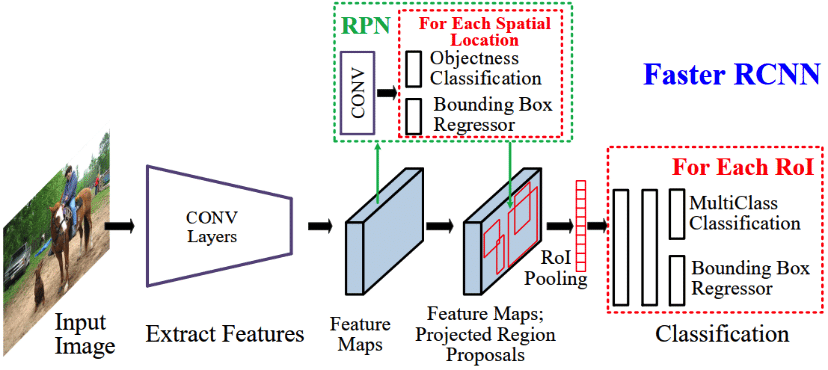

In [42]:
from IPython.display import Image, display
display(Image(filename='./img/faster.png'))

### 1. Подготовка обучающего набора данных
- Реализуем свой класс DetectionDataset, который принимает путь к json файлу с аннотациями, путь к
директории с картинками шаров, а также аугментации.
- Метод getitem возвращает картинку в виде тензора, а также комбинированную метку, состоящую из всех bounding box-ов этой картинки для задачи регрессии - bounding-box представляет из себя координаты [x_min, x_max, y_min, y_max].
- Ещё getitem возвращает метку класса для задачи классификации каждого bounding-box-а. В данной задаче метка принимает 2 значения: мяч или фон.
- Такой формат и ожидает Faster R-CNN.

In [6]:
class DetectionDataset(Dataset):
    def __init__(self, data_dict_file, add_path, transforms=None):
        super().__init__()
        self.add_path = Path(add_path)
        self.transforms = transforms

        with open(data_dict_file, 'r') as f:
            self.annotations = json.load(f)

        self.image_files = list(self.annotations.keys())

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = self.add_path / img_name
        image = cv2.imread(str(img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        h, w = image.shape[:2]

        annots_normalized = self.annotations[img_name]

        if len(annots_normalized) == 0:
            boxes = []
            labels = []
        else:
            boxes = []
            for bbox_norm in annots_normalized:
                x_min = bbox_norm[0] * w
                x_max = bbox_norm[1] * w
                y_min = bbox_norm[2] * h
                y_max = bbox_norm[3] * h
                boxes.append([x_min, y_min, x_max, y_max])

            labels = [1] * len(boxes)

        if self.transforms is not None:
            transformed = self.transforms(
                image=image,
                bboxes=boxes,
                labels=labels
            )
            image = transformed['image']
            boxes = transformed['bboxes']
            labels = transformed['labels']
        else:
            image = image.astype(np.float32) / 255.0
            image = torch.from_numpy(image).permute(2, 0, 1).float()

        boxes = torch.as_tensor(boxes, dtype=torch.float32) if len(boxes) > 0 else torch.zeros((0, 4), dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64) if len(labels) > 0 else torch.zeros((0,), dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([idx])
        }

        return image, target

def collate_fn(batch):
    return tuple(zip(*batch))

Будем использовать следующие аугментации для обучения:
1. Resize - фиксированный размер ускоряет обучение и можно использовать batch_size > 1.
2. HorizontalFlip - горизонтальное отражение.
3. ShiftScaleRotate - сдвигает, масштабирует и поворачивает изображение.
4. RandomBrightnessContrast - изменяет яркость и контраст изображения.
5. HueSaturationValue - измененяет цвета изображения в пространстве HSV (оттенок-насыщенность-яркость), что позволяет изменять цвета мячей,
   а также имитировать разное освещение.
6. MotionBlur - делает размытие изображения, что имитирует размытие при движении камеры или объекта.
7. GaussNoise - Добавляет случайный шум к каждому пикселю изображения.

In [7]:
transform_train = A.Compose([
    A.Resize(height=480, width=640),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(
        shift_limit=0.1,
        scale_limit=0.2,
        rotate_limit=15,
        border_mode=cv2.BORDER_CONSTANT,
        p=0.3
    ),
    A.RandomBrightnessContrast(
        brightness_limit=0.2,
        contrast_limit=0.2,
        p=0.4
    ),
    A.HueSaturationValue(p=0.3),
    A.MotionBlur(blur_limit=7, p=0.15),
    A.GaussNoise(p=0.1),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.3, label_fields=['labels']))

transform_val = A.Compose([
    A.Resize(height=480, width=640),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Будем использовать обычный Dataloader из PyTorch.

In [8]:
!gdown "https://drive.google.com/uc?id=1ZMPIHcEVOZx9OukDOGvmkndkVGYpmIEF" -O seminar_objdet_retina_oi5_ball.zip

Downloading...
From (original): https://drive.google.com/uc?id=1ZMPIHcEVOZx9OukDOGvmkndkVGYpmIEF
From (redirected): https://drive.google.com/uc?id=1ZMPIHcEVOZx9OukDOGvmkndkVGYpmIEF&confirm=t&uuid=67627cbe-59c3-4b56-8375-7c6fab3d1a26
To: /content/seminar_objdet_retina_oi5_ball.zip
100% 1.08G/1.08G [00:18<00:00, 58.0MB/s]


In [10]:
train_dataset = DetectionDataset(data_dict_file="./seminar_objdet_retina_oi5_ball/oi5_ball_filename_to_bbox_train.json",
                                      add_path = './seminar_objdet_retina_oi5_ball/', transforms=transform_train)

train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=8,
    collate_fn=collate_fn
)

val_dataset = DetectionDataset(data_dict_file="./seminar_objdet_retina_oi5_ball/oi5_ball_filename_to_bbox_val.json",
                                      add_path = './seminar_objdet_retina_oi5_ball/', transforms=transform_val)

val_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=8,
    collate_fn=collate_fn
)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


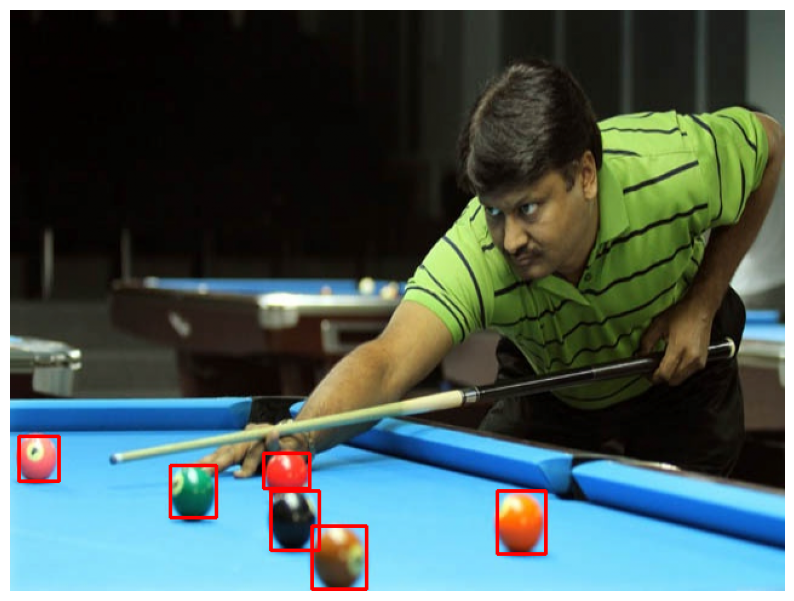

In [11]:
iterator = iter(train_dataset)
image, target = next(iterator)
img_np = inv_normalize(image).permute(1, 2, 0).numpy()
img_with_boxes = draw_boxes(img_np, target)
show_image(img_with_boxes)

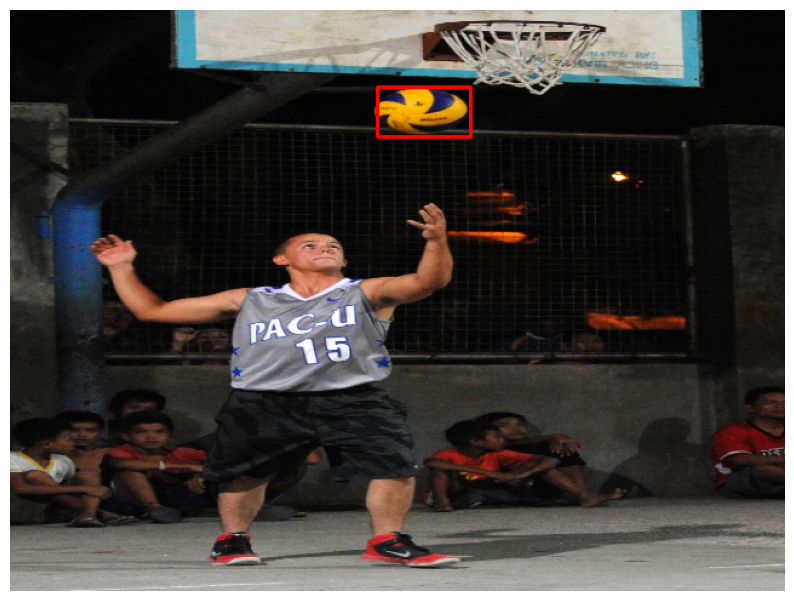

In [12]:
iterator = iter(val_dataset)
image, target = next(iterator)
image, target = next(iterator)
image, target = next(iterator)
image, target = next(iterator)
image, target = next(iterator)
image, target = next(iterator)
img_np = inv_normalize(image).permute(1, 2, 0).numpy()
img_with_boxes = draw_boxes(img_np, target)
show_image(img_with_boxes)

### 2. Реализация корректного train-loop и обучение модели:
Заменим последнюю часть в ROI (Region of Interest) - голову Box Predictor, которая состоит из классификатора для определения класса в боксе
и регрессора, который уточняет координаты бокса.

In [29]:
def faster_rcnn_model(num_classes, pretrained=True):
    model = fasterrcnn_resnet50_fpn(pretrained=pretrained)
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = faster_rcnn_model(num_classes=2, pretrained=True)
model.to(device)

model_no_pretrain = faster_rcnn_model(num_classes=2, pretrained=False)
model_no_pretrain.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

Как на семинаре реализуем функцию для переключения модулей нашей сети в режим обучения. Сделаем так, чтобы можно было учить отдельные модули.
Будем основываться на архитектуре Faster R-CNN:
1. Backbone - состоит из ResNet и Features Pyramid Network, которая генерирует карты признаков.
2. Region Proposals Network (RPN) - генерирует anchors для супер-пикселя каждого уровня пирамиды, после чего для каждого proposol-а
производится задачи бинарной классификации: содержит proposal объект или фон, и задача регрессии, которая изменяет рамки proposol-ов.
После выделения proposol-ов, содержащих объекты, применяется алгоритм  Non Maximum Suppression, который сортирует боксы в порядке убывания вероятности объекта на них, затем берёт самый вероятный бокс и проверяет, с какими боксами выбранный бокс пересекается. Если пересечение сильное, то мы откидываем выбранный бокс.
3. ROI Head - производит многоклассовую классификацию для оставшихся боксов и сдвигает их, т.е. делает задачу регрессии.

Также есть возможность заморозить BatchNorm. Это нужно при первой итерации обучения, когда мы обучаем только roi_head, чтобы
backbone не обновлял веса на основе маленьких статистик из-за маленького batch_size, а наоборот, чтобы  BatchNorm использовал
предобученные статистики исходного датасета, и backbone обучался корректно.

In [31]:
def set_to_training(model, backbone=True, rpn=True, roi_head=True, freeze_bn=False):
    model.train()
    for param in model.parameters():
        param.requires_grad = True

    if not backbone:
        model.backbone.eval()
        for param in model.backbone.parameters():
            param.requires_grad = False
    elif freeze_bn:
        for module in model.backbone.modules():
            if isinstance(module, nn.BatchNorm2d):
                module.eval()
    if not rpn:
        model.rpn.eval()
        for param in model.rpn.parameters():
            param.requires_grad = False

    if not roi_head:
        model.roi_heads.eval()
        for param in model.roi_heads.parameters():
            param.requires_grad = False

Функция для обучения на 1 эпохе.

In [32]:
def train_one_epoch(model, optimizer, scheduler, train_loader, device, epoch_num):
    model.train()
    epoch_loss = []

    for images, targets in tqdm(train_loader):
        optimizer.zero_grad()

        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        if bool(losses == 0):
            continue

        losses.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        epoch_loss.append(losses.item())

    gc.collect()
    torch.cuda.empty_cache()
    avg_loss = np.mean(epoch_loss)

    print('Epoch: {} | Epoch loss: {:1.5f}'.format(epoch_num, avg_loss))
    scheduler.step(avg_loss)

    return avg_loss

Шаг валидации с подсчётом метрики mAP

In [33]:
def val_step(model, dataloader, device):
    model.eval()
    metric_fn = MetricBuilder.build_evaluation_metric(
        "map_2d",
        async_mode=False,
        num_classes=1
    )

    for iter_num, (images, targets) in tqdm(enumerate(dataloader), total=len(dataloader)):
        for img, target in zip(images, targets):
            with torch.no_grad():
                pred = model([img.to(device)])[0]

            boxes = pred['boxes']
            labels = pred['labels']
            scores = pred['scores']

            preds = torch.cat([
                boxes,
                (labels - 1).unsqueeze(1),
                scores.unsqueeze(1)
            ], dim=1).cpu().detach().numpy()

            gt_boxes = target['boxes']
            gt_labels = target['labels']

            zeros = torch.zeros((gt_boxes.shape[0], 2))
            gt = torch.cat([
                gt_boxes,
                (gt_labels - 1).unsqueeze(1),
                zeros
            ], dim=1).cpu().detach().numpy()

            metric_fn.add(preds, gt)

            del img, target, pred, boxes, labels, scores, preds, gt, zeros

        gc.collect()
        torch.cuda.empty_cache()

    map_value = metric_fn.value(iou_thresholds=0.5)['mAP']
    print(f"Val mAP: {map_value:.4f}")

    return map_value

Сначала обучим только новую голову в течение 1 эпохи.

In [34]:
def train_roi_head(model, train_loader, val_loader, device):
    set_to_training(
      model,
      backbone=False,
      rpn=False,
      roi_head=True,
      freeze_bn=True
    )

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.Adam(params, lr=3e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)

    epochs = 1
    for epoch_num in range(1, epochs + 1):
        train_loss = train_one_epoch(
            model,
            optimizer,
            scheduler,
            train_loader,
            device,
            epoch_num
        )

    map_score = val_step(model, val_loader, device)
    return map_score

Функция обучения всей сети

In [35]:
def train_faster_rcnn(model, train_loader, val_loader, device, epochs=5):
    best_map = train_roi_head(model, train_loader, val_loader, device)
    set_to_training(
        model,
        backbone=True,
        rpn=True,
        roi_head=True,
        freeze_bn=False
    )

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.Adam(params, lr=3e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3)

    losses = []
    map_scores = []

    for epoch_num in range(1, epochs + 1):
        loss = train_one_epoch(model, optimizer, scheduler, train_loader, device, epoch_num)
        losses.append(loss)

        map_score = val_step(model, val_loader, device)
        map_scores.append(map_score)

        scheduler.step(map_score)

        if map_score > best_map:
            best_map = map_score
            torch.save(model.state_dict(), 'best_fasterrcnn.pth')

        if epoch_num == epochs:
            torch.save(model.state_dict(), f'fasterrcnn_epoch{epoch_num}.pth')

    return losses, map_scores

Сначала попробуем обучить предобученную модель Faster R-CNN

In [36]:
losses, map_scores = train_faster_rcnn(model, train_loader, val_loader, device)

100%|██████████| 719/719 [05:36<00:00,  2.14it/s]


Epoch: 1 | Epoch loss: 0.51474


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
  0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/mean_average_precision/mean_average_precision_2d.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.match_table[c] = pd.concat([self.match_table[c], match_table], axis=0, join='outer')
100%|██████████| 57/57 [0

Val mAP: 0.3880


  0%|          | 0/719 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 719/719 [13:36<00:00,  1.14s/it]


Epoch: 1 | Epoch loss: 0.29393


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
  0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/mean_average_precision/mean_average_precision_2d.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.match_table[c] = pd.concat([self.match_table[c], match_table], axis=0, join='outer')
100%|██████████| 57/57 [0

Val mAP: 0.5296


  0%|          | 0/719 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 719/719 [13:31<00:00,  1.13s/it]


Epoch: 2 | Epoch loss: 0.25557


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
  0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/mean_average_precision/mean_average_precision_2d.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.match_table[c] = pd.concat([self.match_table[c], match_table], axis=0, join='outer')
100%|██████████| 57/57 [0

Val mAP: 0.4989


  0%|          | 0/719 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 719/719 [13:30<00:00,  1.13s/it]


Epoch: 3 | Epoch loss: 0.23943


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
  0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/mean_average_precision/mean_average_precision_2d.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.match_table[c] = pd.concat([self.match_table[c], match_table], axis=0, join='outer')
100%|██████████| 57/57 [0

Val mAP: 0.5883


  0%|          | 0/719 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 719/719 [13:28<00:00,  1.12s/it]


Epoch: 4 | Epoch loss: 0.22295


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
  0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/mean_average_precision/mean_average_precision_2d.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.match_table[c] = pd.concat([self.match_table[c], match_table], axis=0, join='outer')
100%|██████████| 57/57 [0

Val mAP: 0.6560


  0%|          | 0/719 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 719/719 [13:27<00:00,  1.12s/it]


Epoch: 5 | Epoch loss: 0.21662


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
  0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/mean_average_precision/mean_average_precision_2d.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.match_table[c] = pd.concat([self.match_table[c], match_table], axis=0, join='outer')
100%|██████████| 57/57 [0

Val mAP: 0.6412


А затем обучим непредобученную модель

In [37]:
losses_not_pr, map_scores_not_pr = train_faster_rcnn(model_no_pretrain, train_loader, val_loader, device)

  0%|          | 0/719 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 719/719 [05:31<00:00,  2.17it/s]


Epoch: 1 | Epoch loss: 0.80074


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
  0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/mean_average_precision/mean_average_precision_2d.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.match_table[c] = pd.concat([self.match_table[c], match_table], axis=0, join='outer')
100%|██████████| 57/57 [0

Val mAP: 0.0074


  0%|          | 0/719 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 719/719 [13:31<00:00,  1.13s/it]


Epoch: 1 | Epoch loss: 0.35121


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
  0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/mean_average_precision/mean_average_precision_2d.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.match_table[c] = pd.concat([self.match_table[c], match_table], axis=0, join='outer')
100%|██████████| 57/57 [0

Val mAP: 0.4706


  0%|          | 0/719 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 719/719 [13:27<00:00,  1.12s/it]


Epoch: 2 | Epoch loss: 0.28083


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
  0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/mean_average_precision/mean_average_precision_2d.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.match_table[c] = pd.concat([self.match_table[c], match_table], axis=0, join='outer')
100%|██████████| 57/57 [0

Val mAP: 0.5382


  0%|          | 0/719 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 719/719 [13:27<00:00,  1.12s/it]


Epoch: 3 | Epoch loss: 0.26301


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
  0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/mean_average_precision/mean_average_precision_2d.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.match_table[c] = pd.concat([self.match_table[c], match_table], axis=0, join='outer')
100%|██████████| 57/57 [0

Val mAP: 0.6017


  0%|          | 0/719 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 719/719 [13:25<00:00,  1.12s/it]


Epoch: 4 | Epoch loss: 0.24949


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
  0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/mean_average_precision/mean_average_precision_2d.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.match_table[c] = pd.concat([self.match_table[c], match_table], axis=0, join='outer')
100%|██████████| 57/57 [0

Val mAP: 0.5945


  0%|          | 0/719 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 719/719 [13:25<00:00,  1.12s/it]


Epoch: 5 | Epoch loss: 0.24482


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
  0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/mean_average_precision/mean_average_precision_2d.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.match_table[c] = pd.concat([self.match_table[c], match_table], axis=0, join='outer')
100%|██████████| 57/57 [0

Val mAP: 0.6113


### Сравним графики предобученной модели и непредобученной

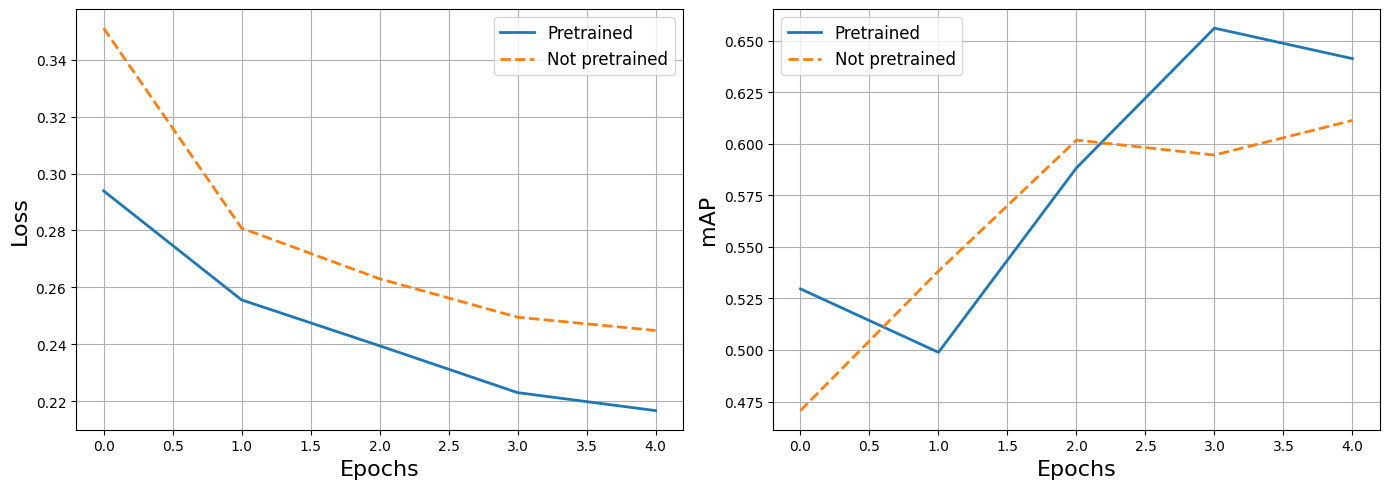

In [39]:
plot(map_scores, losses, map_scores_not_pr, losses_not_pr, ['Pretrained', 'Not pretrained'])

Для иллюстрации результатов выберем случайные изображения из выборки и отрисуем предсказания.

Image 1/1: Detected 1 balls (threshold=0.6)


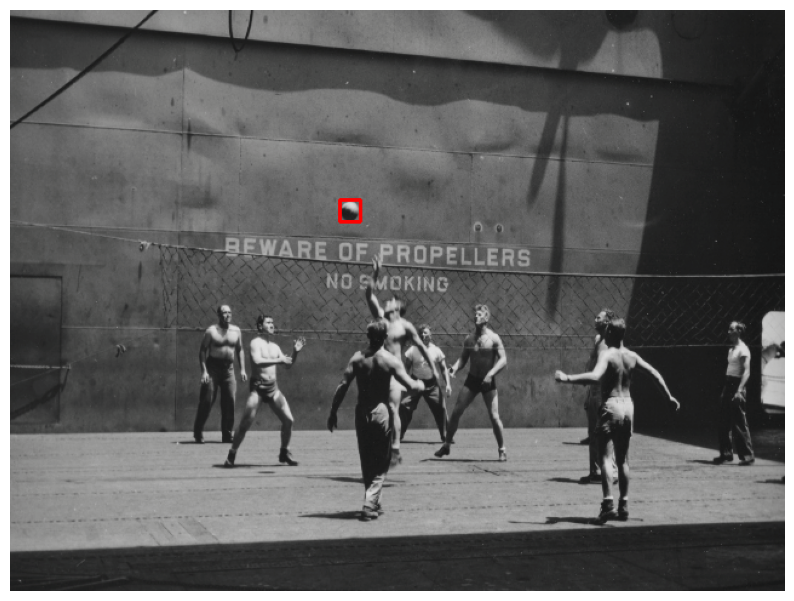

In [49]:
show_predictions(model, val_dataset, device, num_images=1, threshold=0.6)

Image 1/1: Detected 2 balls (threshold=0.6)


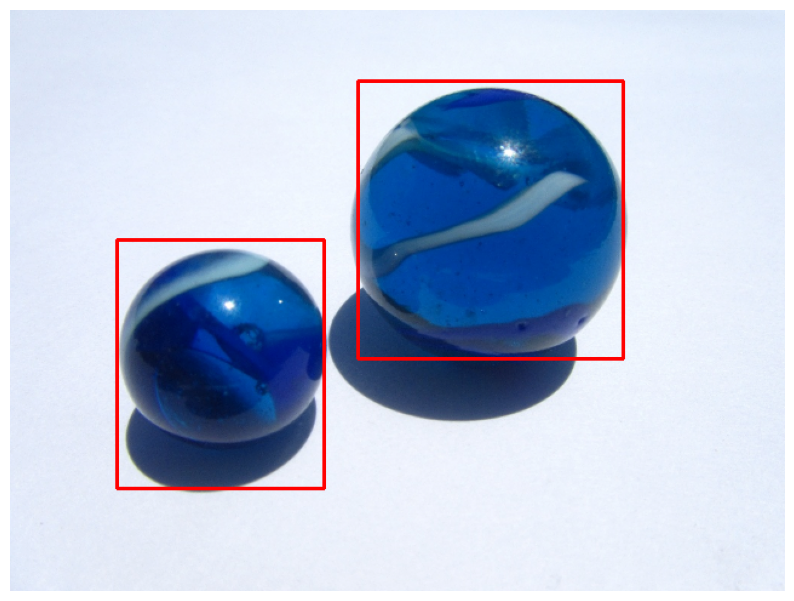

In [50]:
show_predictions(model, val_dataset, device, num_images=1, threshold=0.6)

Image 1/1: Detected 8 balls (threshold=0.6)


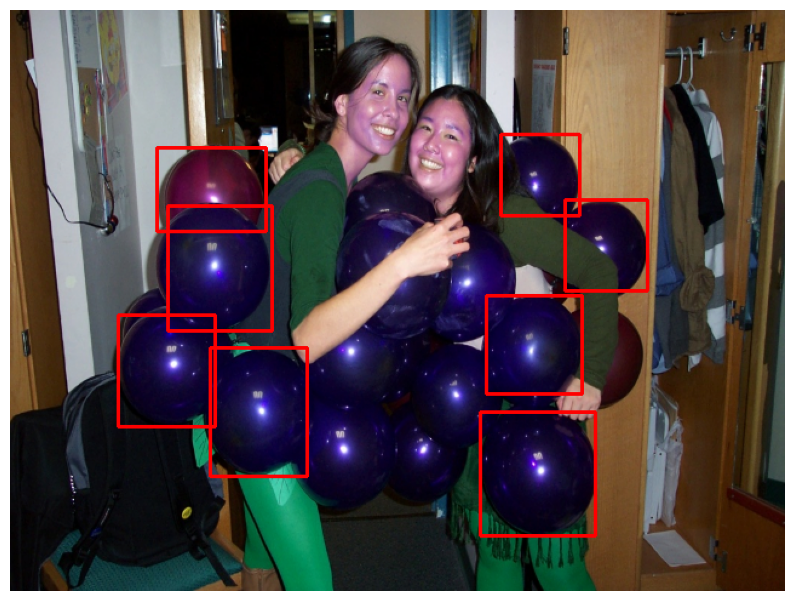

In [51]:
show_predictions(model, val_dataset, device, num_images=1, threshold=0.6)

Image 1/1: Detected 1 balls (threshold=0.7)


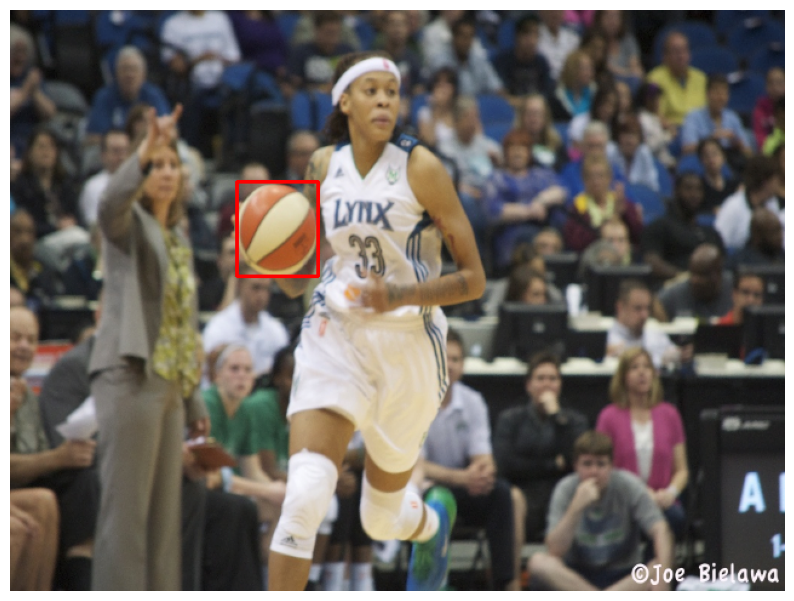

In [52]:
show_predictions(model, val_dataset, device, num_images=1, threshold=0.7)

Image 1/1: Detected 1 balls (threshold=0.6)


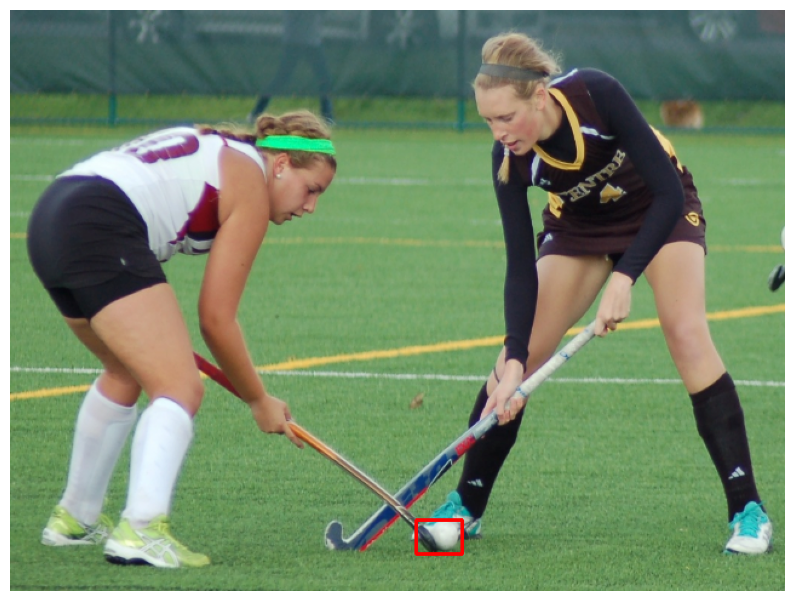

In [53]:
show_predictions(model, val_dataset, device, num_images=1, threshold=0.6)

### Выводы
1. Предобучение модели даёт более быструю сходимость, что видно из графика для Loss, а также лучший mAP.
2. После разморозки BatchNorm у предобученной модели резко падает mAP, что интересно. Скорее всего это происходит, т.к. модель привыкает к Backbone, а после разморозки нужно время на переобучение.
3. В целом качество модели среднее, как будто не так сложно достичь mAP > 0.7 путём подбора начального lr, увеличения числа эпох и, возможно, более плавной разморозки, чтобы избежать скачка после 1 эпохи.
4. Скорее всего модель имеет следующие ошибки:
   - принимает круглые объекты за мячи, например солнце;
   - пропускает маленькие мячи на заднем фоне;
   - неточно определяется boundinx box мячей.
5. Для улучшения результата можно попробовать
увеличить набор данных, сделать их разнообразными. Попробовать всё, что описано в пункте 3, и в целом поэксперементировать с гиперпараметрами.
